# Introduction

#### This notebook will cover price analysis of Airbnb postings in New York City. The data has been sourced from Inside Airbnb's ( http://insideairbnb.com/get-the-data.html) website. The aim of this analysis will be to try and create a visualization on the best time of the year to book an Airbnb in each neighborhood. The final product will be some form of a heatmap that can tell an effective and compelling story, while also answering the above question

### Section: Import and check basic structure

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import missingno as msno
from statsmodels.nonparametric.smoothers_lowess import lowess
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [3]:
project_home_path = os.path.abspath(os.path.dirname(os.getcwd()))
listings_data = pd.read_csv("{}/Airbnb/Data/listings.csv".format(project_home_path))
calendar_data = pd.read_csv("{}/Airbnb/Data/calendar.csv".format(project_home_path))

In [4]:
calendar_data.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,11943,2020-03-14,t,$150.00,$150.00,1,730
1,2060,2020-03-14,t,$100.00,$100.00,1,730
2,2060,2020-03-15,t,$100.00,$100.00,1,730
3,2060,2020-03-16,t,$100.00,$100.00,1,730
4,2060,2020-03-17,t,$100.00,$100.00,1,730


In [5]:
listings_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2060,Modern NYC,2259,Jenny,Manhattan,Washington Heights,40.85722,-73.93790,Private room,100,1,1,2008-09-22,0.01,1,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,7,48,2019-11-04,0.38,2,339
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,313,2020-02-23,4.71,1,151
3,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,78,2019-10-13,0.59,1,0
4,5114,Super Room in Great area.,7345,Yasmine,Manhattan,Lower East Side,40.71910,-73.99040,Private room,94,1,75,2012-06-09,0.56,3,109


In [6]:
calendar_data.info()
#18540540

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18540540 entries, 0 to 18540539
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 990.2+ MB


In [7]:
calendar_data.isna().sum()

listing_id           0
date                 0
available            0
price             1268
adjusted_price    1268
minimum_nights       0
maximum_nights       0
dtype: int64

In [8]:
listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50796 entries, 0 to 50795
Data columns (total 16 columns):
id                                50796 non-null int64
name                              50779 non-null object
host_id                           50796 non-null int64
host_name                         50791 non-null object
neighbourhood_group               50796 non-null object
neighbourhood                     50796 non-null object
latitude                          50796 non-null float64
longitude                         50796 non-null float64
room_type                         50796 non-null object
price                             50796 non-null int64
minimum_nights                    50796 non-null int64
number_of_reviews                 50796 non-null int64
last_review                       40343 non-null object
reviews_per_month                 40343 non-null float64
calculated_host_listings_count    50796 non-null int64
availability_365                  50796 non-null int64

In [9]:
listings_data.drop(['price','minimum_nights'],axis=1, inplace=True)

In [10]:
listings_data.isna().sum()
#no reviews is not something very uncommon, since all the columns are strings, we can just fillna will "BLANK"

id                                    0
name                                 17
host_id                               0
host_name                             5
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
number_of_reviews                     0
last_review                       10453
reviews_per_month                 10453
calculated_host_listings_count        0
availability_365                      0
dtype: int64

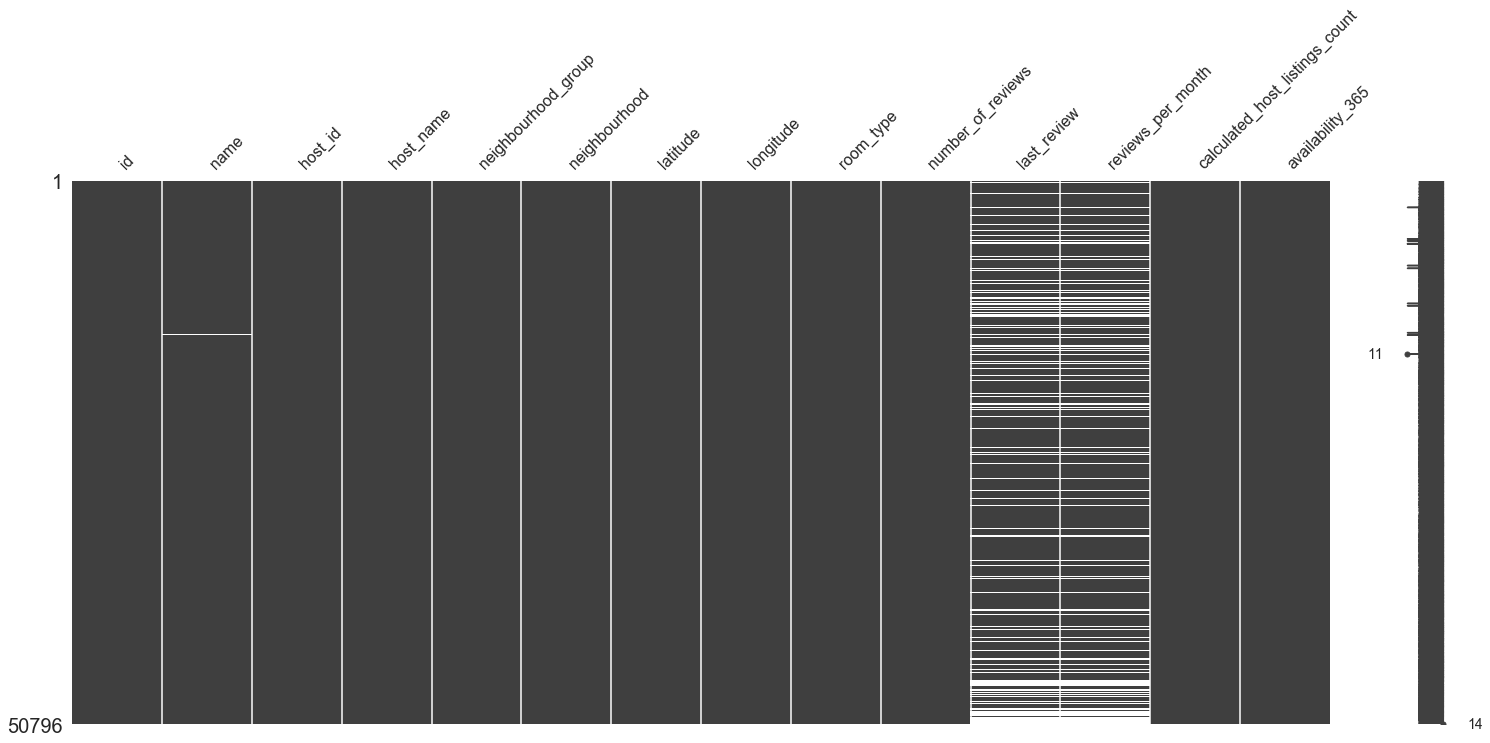

In [11]:
sns.set(rc={'figure.figsize':(20,18)})
msno.matrix(listings_data)

In [12]:
calendar_data.fillna(0, inplace=True)

In [13]:
listings_data.fillna('BLANK', inplace=True)

In [14]:
calendar_data.listing_id.nunique()

50796

In [15]:
listings_data.id.nunique()

50796

In [16]:
calendar_data.date = pd.to_datetime(calendar_data.date)

In [17]:
#confirm the range of data being looked at
calendar_data.date.describe()

count                18540540
unique                    366
top       2020-07-05 00:00:00
freq                    50796
first     2020-03-14 00:00:00
last      2021-03-14 00:00:00
Name: date, dtype: object

In [18]:
calendar_data.price = calendar_data.price.replace('[\$,]', '', regex=True).astype(float)

In [19]:
calendar_data.price.describe()

count    1.854054e+07
mean     1.581478e+02
std      2.912378e+02
min      0.000000e+00
25%      6.800000e+01
50%      1.070000e+02
75%      1.800000e+02
max      1.000000e+04
Name: price, dtype: float64

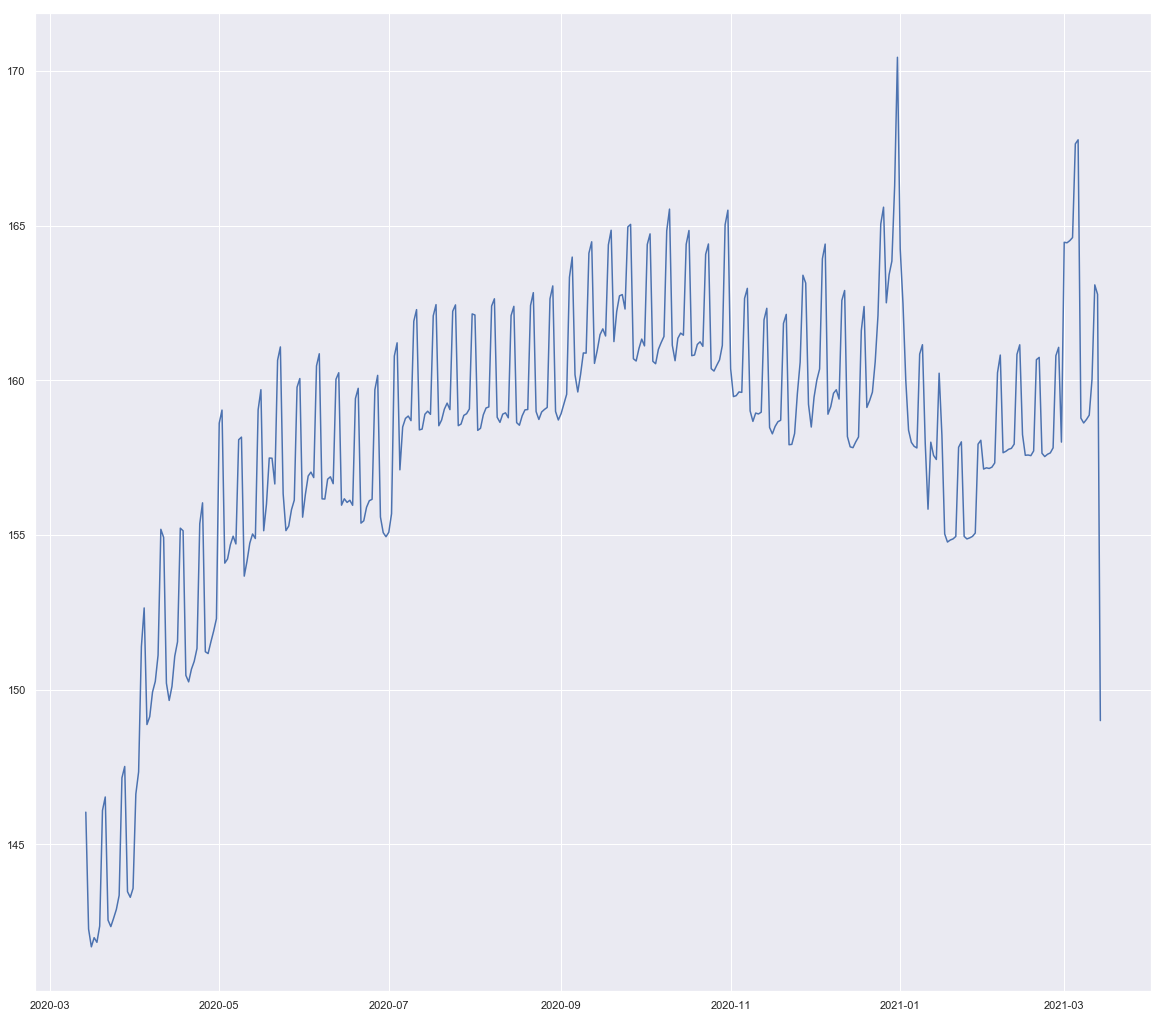

In [20]:
#all_shorts_grouped = shorts.groupby(['Shortage_Percent_Buckets', 'Sample_Group','CSV_Loan_Locked']).agg(func)
plt.plot(calendar_data.groupby(['date']).agg({'price': 'mean'}))

In [21]:
#sns.lineplot(x='date', y='price', data=calendar_data).set_title('Price Movement', size=20)

In [22]:
calendar_data['isWeekend'] = ((pd.DatetimeIndex(calendar_data.date).dayofweek) // 5 == 1).astype(float)

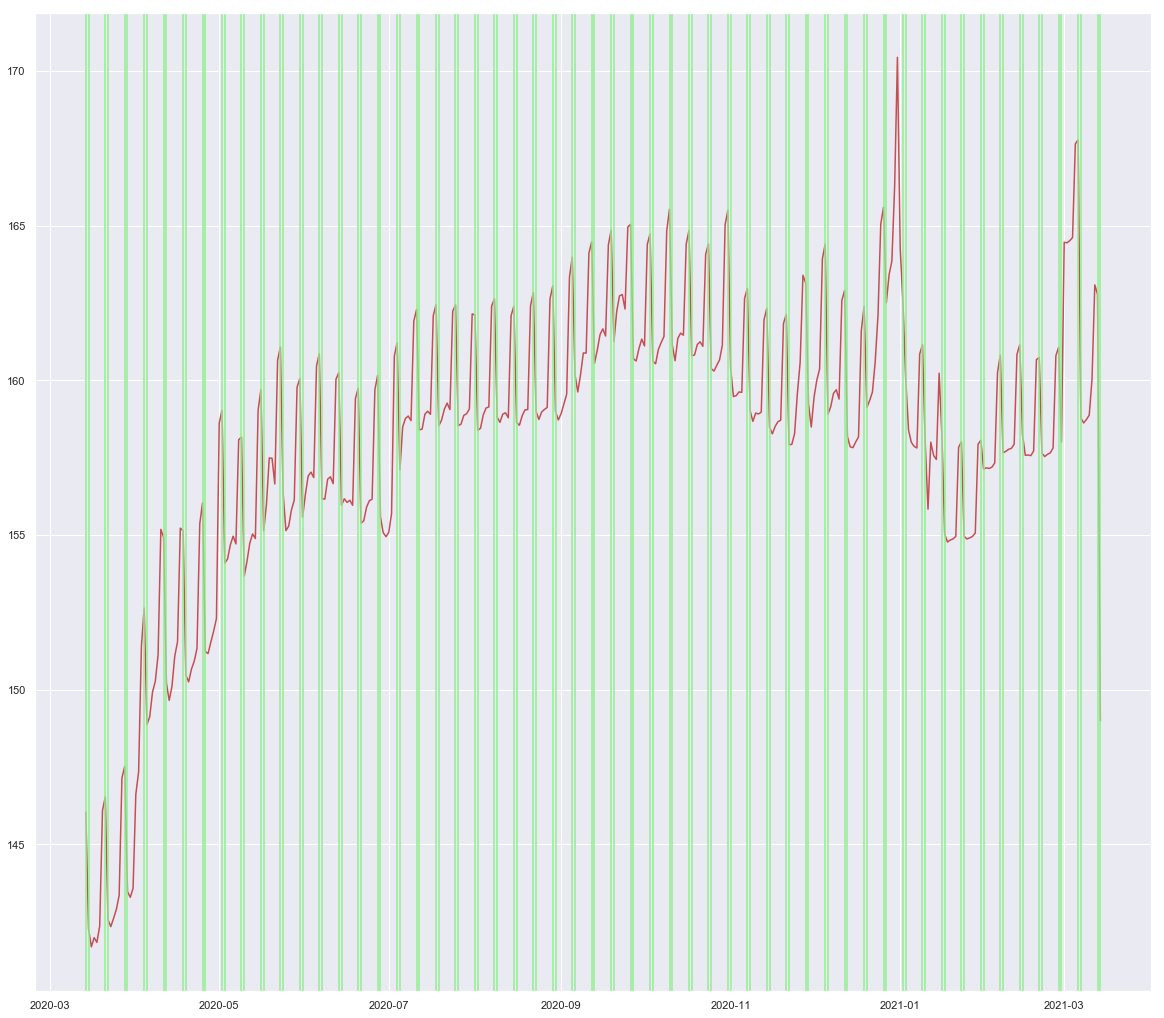

In [23]:
vert_weekends = (calendar_data[calendar_data['isWeekend']== 1.0]['date']).drop_duplicates()
plt.plot(calendar_data.groupby(['date']).agg({'price': 'mean'}), color='r')
for date in vert_weekends:
    plt.axvline(x=date, color='lightgreen', linestyle='-')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a228418d0>]],
      dtype=object)

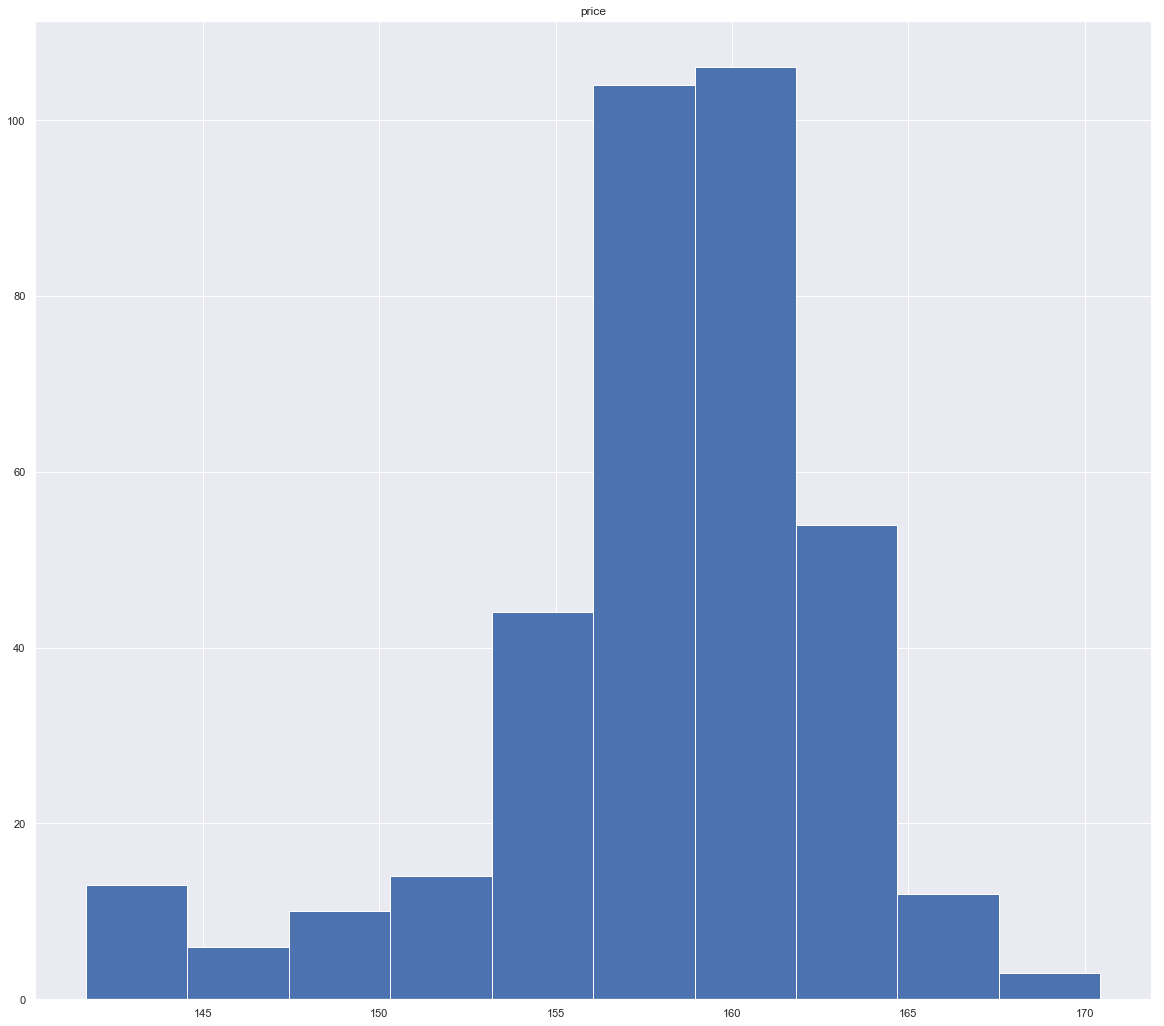

In [24]:
calendar_data.groupby(['date']).agg({'price': 'mean'}).hist()

In [25]:
nyc_listings = calendar_data.merge(listings_data, left_on='listing_id', right_on='id')
nyc_listings.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights', 'isWeekend', 'id', 'name',
       'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [32]:
nyc_listings['WeekNumber'] = nyc_listings.date.dt.week
nyc_listings.shape

(4798655, 23)

In [33]:
nyc_listings.room_type.value_counts()

Entire home/apt    2779475
Private room       2019180
Name: room_type, dtype: int64

In [34]:
#take listings with more than 200 days of availability and also look at reducing size of neighborhoods
#filter out hotels and shared rooms because I want to focus on Entire home/apt and private room
nyc_listings = nyc_listings.loc[nyc_listings['room_type'].isin(['Entire home/apt', 'Private room'])]
nyc_listings = nyc_listings.loc[nyc_listings['availability_365']> 182]
# nyc_listings.neighbourhood.value_counts()

In [35]:
unique_listings= nyc_listings.groupby('neighbourhood')['listing_id'].nunique().reset_index()

In [36]:
unique_listings.columns = ['neighbourhood','id_count']
unique_listings_names_used = unique_listings.loc[unique_listings['id_count'] > 15]['neighbourhood']
nyc_listings = nyc_listings.loc[nyc_listings['neighbourhood'].isin(unique_listings_names_used)]

In [37]:
apt_nyc_listings = nyc_listings.loc[nyc_listings['room_type']=='Entire home/apt']
room_nyc_listings = nyc_listings.loc[nyc_listings['room_type']=='Private room']

In [45]:
#pd.crosstab(cnt_lock['LoanBuckets'], cnt_lock['FICOBuckets'], values = cnt_lock['TFBOS_rate'], aggfunc='mean')
prices_apt = pd.crosstab(apt_nyc_listings['neighbourhood'], apt_nyc_listings['WeekNumber'], values=apt_nyc_listings['price'], aggfunc='mean')#.reset_index()
prices_apt.head()

WeekNumber,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
neighbourhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,154.385714,154.414286,154.457143,154.542857,155.300000,158.328571,158.285714,158.314286,158.285714,158.333333,150.400000,149.657143,150.100000,150.728571,151.400000,150.842857,151.514286,151.700000,151.700000,154.800000,154.471429,152.971429,157.914286,158.128571,158.657143,158.685714,161.157143,161.857143,157.071429,157.071429,157.142857,158.071429,158.071429,158.071429,158.071429,155.642857,155.628571,155.671429,155.671429,153.200000,149.871429,149.871429,149.857143,150.414286,153.571429,154.014286,153.985714,153.942857,153.114286,153.000000,153.000000,153.000000,153.757143
Arverne,384.685714,384.685714,384.685714,384.685714,384.685714,384.685714,384.685714,384.685714,384.685714,387.150000,388.025000,376.178571,376.335714,380.957143,385.685714,385.657143,386.850000,388.850000,390.214286,391.414286,398.071429,393.157143,399.371429,400.764286,401.978571,401.221429,412.764286,406.621429,404.800000,408.050000,404.714286,406.607143,405.107143,408.678571,408.142857,410.107143,401.128571,395.435714,395.435714,392.721429,388.864286,388.750000,388.064286,388.064286,388.064286,388.064286,388.064286,389.492857,385.414286,385.078571,385.078571,388.164286,388.107143
Astoria,182.015699,180.695447,180.814757,180.919937,183.379906,183.916797,183.843014,183.797488,184.599686,184.967033,168.104396,164.990581,165.951334,173.979592,178.756672,183.453689,184.224490,186.141287,190.386185,189.558870,191.703297,190.819466,191.265306,192.219780,191.901099,191.780220,193.560440,193.273155,192.291994,192.175824,193.368917,193.069074,192.715856,194.130298,193.621664,193.962323,192.315542,191.000000,190.657771,190.365777,190.003140,189.511774,189.411303,189.711146,186.726845,186.646782,186.860283,188.313972,187.163265,187.759812,189.059655,198.551020,202.737834
Bay Ridge,234.931429,235.040000,233.720000,232.022857,232.177143,232.857143,232.822857,232.794286,232.811429,233.220000,225.100000,222.308571,223.445714,229.034286,231.011429,232.308571,233.748571,233.285714,233.542857,235.622857,235.537143,235.142857,237.502857,237.422857,237.114286,237.525714,237.817143,237.617143,236.320000,237.085714,237.297143,234.097143,236.302857,234.651429,236.160000,234.914286,236.262857,235.228571,234.777143,237.725714,238.268571,238.280000,236.800000,235.948571,238.857143,239.217143,240.120000,239.457143,240.222857,240.800000,240.885714,241.931429,241.760000
Bayside,1454.591837,1454.591837,1454.591837,1454.591837,1447.244898,1454.591837,1454.591837,1454.591837,1454.591837,1455.023810,1454.428571,1381.408163,1402.653061,1390.795918,1427.061224,1451.020408,1451.489796,1451.204082,1430.346939,1452.551020,1451.959184,1423.102041,1441.326531,1462.244898,1445.816327,1445.061224,1569.571429,1450.897959,1450.734694,1432.632653,1450.734694,1450.734694,1443.469388,1448.285714,1414.000000,1441.244898,1443.632653,1446.959184,1424.918367,1454.306122,1454.306122,1447.142857,1454.306122,1454.306122,1454.306122,1447.142857,1454.306122,1447.142857,1447.387755,1447.428571,1454.591837,1447.428571,1447.428571


In [53]:
df_first_week_price = prices_apt.iloc[:, 0]
heatmap_prices_apt = (prices_apt.divide(df_first_week_price, axis=0)*100)-100
heatmap_prices_apt.head()

WeekNumber,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
neighbourhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0.0,0.018507,0.046266,0.101786,0.592209,2.553900,2.526140,2.544647,2.526140,2.556985,-2.581660,-3.062830,-2.775979,-2.368835,-1.933932,-2.294809,-1.859906,-1.739613,-1.739613,0.268345,0.055520,-0.916073,2.285556,2.424355,2.766725,2.785232,4.386046,4.839456,1.739613,1.739613,1.785880,2.387342,2.387342,2.387342,2.387342,0.814287,0.805034,0.832794,0.832794,-0.768021,-2.924031,-2.924031,-2.933284,-2.572407,-0.527436,-0.240585,-0.259091,-0.286851,-0.823540,-0.897566,-0.897566,-0.897566,-0.407144
Arverne,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.640597,0.868056,-2.211453,-2.170603,-0.969251,0.259952,0.252525,0.562611,1.082516,1.437166,1.749109,3.479649,2.202169,3.817588,4.179664,4.495321,4.298500,7.299094,5.702243,5.228758,6.073604,5.206477,5.698529,5.308601,6.237002,6.097742,6.608363,4.274361,2.794489,2.794489,2.088904,1.086230,1.056521,0.878268,0.878268,0.878268,0.878268,0.878268,1.249629,0.189394,0.102124,0.102124,0.904263,0.889409
Astoria,0.0,-0.725350,-0.659801,-0.602015,0.749500,1.044470,1.003933,0.978921,1.419651,1.621472,-7.642914,-9.353653,-8.825812,-4.415062,-1.790520,0.790037,1.213517,2.266611,4.598772,4.144242,5.322397,4.836818,5.081764,5.606155,5.431070,5.364659,6.342717,6.184882,5.645829,5.582005,6.237494,6.072759,5.878700,6.655799,6.376354,6.563513,5.658766,4.936004,4.747982,4.587560,4.388325,4.118367,4.063168,4.227903,2.588318,2.544332,2.661630,3.460291,2.828089,3.155834,3.869972,9.084558,11.384806
Bay Ridge,0.0,0.046214,-0.515652,-1.238051,-1.172379,-0.882932,-0.897526,-0.909688,-0.902391,-0.728480,-4.184808,-5.372996,-4.888965,-2.510155,-1.668572,-1.116435,-0.503490,-0.700508,-0.591054,0.294311,0.257826,0.089996,1.094544,1.060492,0.929146,1.104274,1.228322,1.143191,0.591054,0.916985,1.006981,-0.355119,0.583757,-0.119184,0.522949,-0.007297,0.566731,0.126481,-0.065673,1.189405,1.420475,1.425340,0.795369,0.432953,1.671004,1.824241,2.208547,1.926398,2.252329,2.497993,2.534478,2.979593,2.906623
Bayside,0.0,0.000000,0.000000,0.000000,-0.505086,0.000000,0.000000,0.000000,0.000000,0.029697,-0.011224,-5.031217,-3.570677,-4.385830,-1.892669,-0.245528,-0.213259,-0.232901,-1.666784,-0.140302,-0.180989,-2.164854,-0.911961,0.526131,-0.603297,-0.655209,7.904595,-0.253946,-0.265170,-1.509646,-0.265170,-0.265170,-0.764644,-0.433532,-2.790600,-0.917573,-0.753420,-0.524728,-2.039986,-0.019642,-0.019642,-0.512101,-0.019642,-0.019642,-0.019642,-0.512101,-0.019642,-0.512101,-0.495265,-0.492459,0.000000,-0.492459,-0.492459


In [57]:
heatmap_prices_apt.info()
#heatmap_prices_apt.min

<class 'pandas.core.frame.DataFrame'>
Index: 103 entries, Allerton to Woodside
Data columns (total 53 columns):
1     103 non-null float64
2     103 non-null float64
3     103 non-null float64
4     103 non-null float64
5     103 non-null float64
6     103 non-null float64
7     103 non-null float64
8     103 non-null float64
9     103 non-null float64
10    103 non-null float64
11    103 non-null float64
12    103 non-null float64
13    103 non-null float64
14    103 non-null float64
15    103 non-null float64
16    103 non-null float64
17    103 non-null float64
18    103 non-null float64
19    103 non-null float64
20    103 non-null float64
21    103 non-null float64
22    103 non-null float64
23    103 non-null float64
24    103 non-null float64
25    103 non-null float64
26    103 non-null float64
27    103 non-null float64
28    103 non-null float64
29    103 non-null float64
30    103 non-null float64
31    103 non-null float64
32    103 non-null float64
33    103 non-null float